# Tutorial HANNAH Framework 
## AutoML School
### Hannover 2024 


### Setup tooling

In [38]:
!pip install  "hannah[vision,performancemodel]@git+https://github.com/ekut-es/hannah.git@pub/automlschool24"


### Setup library

In [39]:
import hannah
import pathlib
import torch
import os
from contextlib import contextmanager
import sys
import nn_meter
import tvm
from IPython.display import Code, display



# Modify the python module search path to include the current directory
sys.path.append(str(pathlib.Path.cwd()))


@contextmanager
def change_wd(path: pathlib.Path, create: bool = True, clean: bool = False):
    current = pathlib.Path.cwd()
    
    if clean and path.exists():
        import shutil
        shutil.rmtree(path)
        path.mkdir(parents=True)
    
    if create and not path.exists():
        path.mkdir(parents=True)    
    
    try:
        os.chdir(path)
        yield
    finally:
        os.chdir(current)
    
# Setup logging
import logging
logging.basicConfig(level=logging.INFO)


### Create Search Space
First we create a simple search space. This search space description is written to a file such that the `hydra` config framework
can refer to it and instantiate the search space. 

The search space consists of a variable number of `conv_relu` blocks with a `linear` layer at the end. 



In [40]:
%%writefile space.py
from hannah.nas.functional_operators.op import ChoiceOp, Tensor, scope
from hannah.nas.functional_operators.operators import AdaptiveAvgPooling, Conv2d, Linear, Relu
from hannah.nas.functional_operators.op import search_space
from hannah.nas.parameters.parameters import CategoricalParameter, IntScalarParameter


@scope
def conv_relu(input, kernel_size, out_channels, stride):
    in_channels = input.shape()[1]
    weight = Tensor(name='weight',
                    shape=(out_channels, in_channels, kernel_size, kernel_size),
                    axis=('O', 'I', 'kH', 'kW'),
                    grad=True)

    conv = Conv2d(stride=stride)(input, weight)
    relu = Relu()(conv)
    return relu


def adaptive_avg_pooling(input):
    return AdaptiveAvgPooling()(input)


def dynamic_depth(*exits, switch):
    return ChoiceOp(*exits, switch=switch)()


def linear(input, out_features):
    input_shape = input.shape()
    in_features = input_shape[1] * input_shape[2] * input_shape[3]
    weight = Tensor(name='weight',
                    shape=(in_features, out_features),
                    axis=('in_features', 'out_features'),
                    grad=True)

    out = Linear()(input, weight)
    return out


@scope
def classifier_head(input, num_classes):
    out = adaptive_avg_pooling(input)
    out = linear(out, num_classes)
    return out


@search_space
def cnn_search_space(name, input, max_blocks=3, max_channels=64, num_classes=10):
    out_channels = IntScalarParameter(16, max_channels, step_size=8, name="out_channels")
    kernel_size = CategoricalParameter([3, 5, 7, 9], name="kernel_size")
    stride = CategoricalParameter([1, 2], name="stride")
    num_blocks = IntScalarParameter(1, max_blocks, name="num_blocks")
    exits = []
    out = input
    for i in range(num_blocks.max + 1):
        out = conv_relu(out,
                        stride=stride.new(),
                        out_channels=out_channels.new(),
                        kernel_size=kernel_size.new())
        exits.append(out)

    out = dynamic_depth(*exits, switch=num_blocks)
    out = classifier_head(out, num_classes=num_classes)
    return out

Overwriting space.py


Now we create a config file for `hydra`:

In [41]:
from omegaconf import OmegaConf
import os

cfg_dict ={"_target_": "space.cnn_search_space",
           "name": "cnn_search_space",
           "num_classes": 10,
           "max_channels": 32,
           "max_blocks": 2}

cfg = OmegaConf.create(cfg_dict)

if not os.path.exists("model"):
    os.mkdir("model")
OmegaConf.save(config=cfg, f="model/cnn_search_space.yaml")


### Configure NAS

In [42]:
%%writefile config.yaml

defaults:
    - base_config
    - override dataset: mnist   # Dataset configuration name
    - override features: identity        # Feature extractor configuration name (use identity for vision datasets)
    # - override model: timm_mobilenetv3_small_075      # Neural network name (for now timm_resnet50 or timm_efficientnet_lite1)
    - override scheduler: 1cycle         # learning rate scheduler config name
    - override optimizer: adamw          # Optimizer config name
    - override normalizer: null          # Feature normalizer (used for quantized neural networks)
    - override module: image_classifier  # Lightning module config for the training loop (image classifier for image classification tasks)
    - _self_


dataset:
  data_folder: ${oc.env:HANNAH_DATA_FOLDER,${hydra:runtime.cwd}/../../datasets/}

module:
  batch_size: 128
  num_workers: 0

nas:
  budget: 5
  total_candidates: 5
  num_selected_candidates: 10

trainer:
  max_epochs: 2
  devices: null
  accelerator: cpu 
  enable_progress_bar: False

scheduler:
  max_lr: 0.001

fx_mac_summary: True

Overwriting config.yaml


### Run NAS

Now we can run the NAS in the "terminal". Note, that we have to append the current working directory to the PYTHONPATH such 
that the search space located in our current directory can be found. If the model file where to be located in the `hannah/models/`
directory that would not be necessary.

In [43]:
from hannah.tools.train import main
from hydra import compose, initialize_config_module

wd = pathlib.Path.cwd()

with initialize_config_module("hannah.conf", version_base="1.2"):
    cfg = compose(config_name="config", overrides=["model=cnn_search_space", "nas=random_nas", "trainer.max_epochs=1", "dataset=mnist", f"dataset.data_folder={wd / 'data'}", "module.num_workers=8", "nas.presample=false"])
    
    with change_wd(wd / "run1", create=True, clean=False):
        main(cfg)

INFO:hannah.utils.utils:Environment info:
INFO:hannah.utils.utils:  Number of GPUs: 2
INFO:hannah.utils.utils:  CUDA version: 12.1
INFO:hannah.utils.utils:  CUDNN version: 8907
INFO:hannah.utils.utils:  Kernel: 4.18.0-553.16.1.el8_10.x86_64
INFO:hannah.utils.utils:  Python: 3.11.9 (main, Jun 24 2024, 06:19:13) [GCC 8.5.0 20210514 (Red Hat 8.5.0-22)]
INFO:hannah.utils.utils:  PyTorch: 2.2.2+cu121
INFO:hannah.utils.utils:  Pytorch Lightning: 2.4.0
INFO:hannah.utils.utils:  Numpy: 1.26.4
INFO:hannah.utils.utils:  Hannah version info:
INFO:hannah.utils.utils:    Cannot find a Git repository.  You probably downloaded an archive
INFO:hannah.utils.utils:  Command line: /local/gerum/.cache/pypoetry/virtualenvs/hannah-8Yp6PnCx-py3.11/lib/python3.11/site-packages/ipykernel_launcher.py --f=/home/gerum/.local/share/jupyter/runtime/kernel-v2-2282314ierSxxYLBysL.json
INFO:hannah.utils.utils:  



 **                                            **
/**                                           /**
/**       ******   *******  *******   ******  /**
/******  //////** //**///**//**///** //////** /******
/**///**  *******  /**  /** /**  /**  ******* /**///**
/**  /** **////**  /**  /** /**  /** **////** /**  /**
/**  /**//******** ***  /** ***  /**//********/**  /**
//   //  //////// ///   // ///   //  //////// //   //

dataset:
  data_folder: /local/gerum/hannah/tutorials/automlschool24/data
  cls: hannah.datasets.vision.MNISTDataset
  dataset: mnist
  val_percent: 0.1
features:
  _target_: torch.nn.Identity
model:
  _target_: space.cnn_search_space
  name: cnn_search_space
  num_classes: 10
  max_channels: 32
  max_blocks: 2
scheduler:
  _target_: torch.optim.lr_scheduler.OneCycleLR
  max_lr: 0.001
  pct_start: 0.3
  anneal_strategy: cos
  cycle_momentum: true
  base_momentum: 0.85
  max_momentum: 0.95
  div_factor: 25.0
  final_div_factor: 10000.0
  last_epoch: -1
optimizer:
  _tar

INFO:hannah.nas.search.sampler.base_sampler:Loaded 5 points from history
INFO:hannah.callbacks.optimization:Monitoring the following values for optimization
INFO:hannah.callbacks.optimization:  - val_error direction: minimize(1)


### Evaluate

The results of the neural architecture search are then saved in `run1/history.yml`

In [44]:
import pandas as pd 
import yaml

history = yaml.unsafe_load((wd / "run1" / "history.yml").read_text())

df = pd.DataFrame((item.result for item in history))
df

,est_act,ff,total_act,total_macs,total_weights,val_error
0,25088.0,0.016657,35338.0,3801072.0,19200.0,1.0
1,25088.0,0.089107,41626.0,3475008.0,55248.0,1.0
2,25088.0,0.018954,63578.0,3023424.0,7632.0,1.0
3,25088.0,0.040623,33754.0,5394080.0,28592.0,1.0
4,50176.0,0.141228,101210.0,22102848.0,28512.0,1.0


# Getting Hardware into the Picture

## Hardware aware NAS

Many approaches to integrate hardware properties into the optimization loop use hardware measurements of inference latency or energy consumption as target functions for the optimization loop. We can do the same, by using

1. By directly measuring the neural network`s  exection time using a compilation backend
2. By using a prefitted estimator that predicts the performance measurements
3. By using a hardware model that estimates harware metrics using analytical or functional modeling

## Hardware Aware-NAS

In this case we use a pretrained performance estimator [nn-meter](https://github.com/microsoft/nn-Meter). 

The performance estimator has been pretrained for the following devices and inference frameworks:

|       Device       |   Framework   |   Processor   |      Hardware name      |
| :-----------------: | :------------: | :------------: | :----------------------: |
|       Pixel4       |  TFLite v2.1  | CortexA76 CPU |    cortexA76cpu_tflite21  |
|         Mi9         |  TFLite v2.1  | Adreno 640 GPU |    adreno640gpu_tflite21  |
|      Pixel3XL      |  TFLite v2.1  | Adreno 630 GPU |   adreno630gpu_tflite21  |
| Intel Movidius NCS2 | OpenVINO2019R2 |   Myriad VPU   |   myriadvpu_openvino2019r2 |

`nn-meter` has been integrated into hannah and can be used as a performance estimator by adding it to the configuration. 

Using the overwrites: `nas/predictor=nn-meter nas.predictor.nn_meter.hardware_name=<hardware_name>

The following adds the `nn-meter` predictor to the list of predictors, and configures the multiobjective optimization to also consider the reported duration per inference, searching for models with an uper execution time bound of 0.1 ms on the given target hardware. 

In [45]:
from hannah.tools.train import main
from hydra import compose, initialize_config_module

wd = pathlib.Path.cwd()

with initialize_config_module("hannah.conf", version_base="1.2"):
    cfg = compose(config_name="config", overrides=["nas/predictor=[nn-meter,macs,gcn]", "+hannah.nas.bounds.duration=0.2", "model=cnn_search_space", "nas=random_nas", "trainer.max_epochs=1", "dataset=mnist", f"dataset.data_folder={wd / 'data'}", "module.num_workers=8", "nas.presample=false"])
    
    with change_wd(wd / "run_nn_meter", create=True, clean=False):
        main(cfg)

INFO:hannah.utils.utils:Environment info:
INFO:hannah.utils.utils:  Number of GPUs: 2
INFO:hannah.utils.utils:  CUDA version: 12.1
INFO:hannah.utils.utils:  CUDNN version: 8907
INFO:hannah.utils.utils:  Kernel: 4.18.0-553.16.1.el8_10.x86_64
INFO:hannah.utils.utils:  Python: 3.11.9 (main, Jun 24 2024, 06:19:13) [GCC 8.5.0 20210514 (Red Hat 8.5.0-22)]
INFO:hannah.utils.utils:  PyTorch: 2.2.2+cu121
INFO:hannah.utils.utils:  Pytorch Lightning: 2.4.0
INFO:hannah.utils.utils:  Numpy: 1.26.4
INFO:hannah.utils.utils:  Hannah version info:
INFO:hannah.utils.utils:    Cannot find a Git repository.  You probably downloaded an archive
INFO:hannah.utils.utils:  Command line: /local/gerum/.cache/pypoetry/virtualenvs/hannah-8Yp6PnCx-py3.11/lib/python3.11/site-packages/ipykernel_launcher.py --f=/home/gerum/.local/share/jupyter/runtime/kernel-v2-2282314ierSxxYLBysL.json
INFO:hannah.utils.utils:  
INFO:hannah.nas.search.sampler.base_sampler:Loaded 5 points from history



 **                                            **
/**                                           /**
/**       ******   *******  *******   ******  /**
/******  //////** //**///**//**///** //////** /******
/**///**  *******  /**  /** /**  /**  ******* /**///**
/**  /** **////**  /**  /** /**  /** **////** /**  /**
/**  /**//******** ***  /** ***  /**//********/**  /**
//   //  //////// ///   // ///   //  //////// //   //

dataset:
  data_folder: /local/gerum/hannah/tutorials/automlschool24/data
  cls: hannah.datasets.vision.MNISTDataset
  dataset: mnist
  val_percent: 0.1
features:
  _target_: torch.nn.Identity
model:
  _target_: space.cnn_search_space
  name: cnn_search_space
  num_classes: 10
  max_channels: 32
  max_blocks: 2
scheduler:
  _target_: torch.optim.lr_scheduler.OneCycleLR
  max_lr: 0.001
  pct_start: 0.3
  anneal_strategy: cos
  cycle_momentum: true
  base_momentum: 0.85
  max_momentum: 0.95
  div_factor: 25.0
  final_div_factor: 10000.0
  last_epoch: -1
optimizer:
  _tar

https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(

https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/dwconv-bn-relu.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/relu.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/maxpool.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/hswish.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/se.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/avgpool.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/bn.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/conv-bn-relu.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/bnrelu.pkl


INFO:hannah.callbacks.optimization:Monitoring the following values for optimization
INFO:hannah.callbacks.optimization:  - val_error direction: minimize(1)


The search yielded the following results:

In [46]:
import pandas as pd 
import yaml

history = yaml.unsafe_load((wd / "run_nn_meter" / "history.yml").read_text())

df = pd.DataFrame((item.result for item in history))
df

,duration,est_act,ff,total_act,total_macs,total_weights,val_error
0,0.177172,50176.0,0.011888,88666.0,5588672.0,7448.0,1.0
1,0.301446,12544.0,0.070836,22810.0,7757216.0,39896.0,1.0
2,0.087591,12544.0,0.001603,14938.0,382752.0,5568.0,1.0
3,0.422865,9408.0,0.085053,13402.0,3429536.0,64472.0,1.0
4,1.620987,50176.0,0.530806,101210.0,65254208.0,83552.0,1.0


As the number of multiply accumulate operations is often used as a first order approximation we can also have a look at a comparison of the number of MAC operations in the networks versus their actual runtimes. 

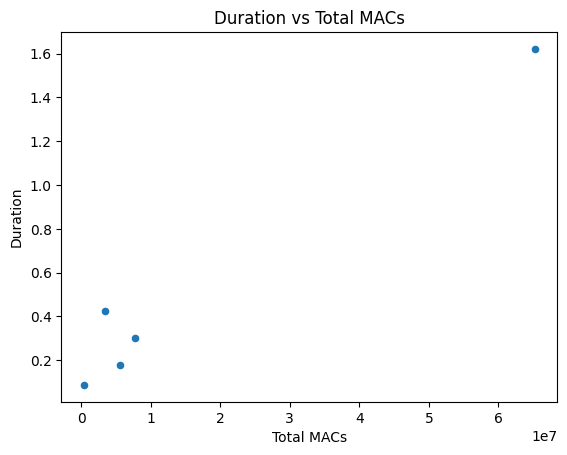

In [47]:
import matplotlib.pyplot as plt

df.plot(x='total_macs', y='duration', kind='scatter')
plt.xlabel('Total MACs')
plt.ylabel('Duration')
plt.title('Duration vs Total MACs')
plt.show()

## Taking hardware-deployment into consideration

The neural architecture search so far has been hardware-aware but did not consider any specific hardware-optimizations. Going one step-further we do not only optimize over the neural network architecture space but also over the neural network architectures. For this purpose we make use of the neural network compilation framework tvm. 

In TVM neural network operators can be represented using a lower level of abstraction than a graph of machine learning operators, it is more closely related to a lower level programming language like C but the compiler toolchain allows to expose mapping decisions to an external optimizer like a neural architecture search. 

For demonstration purposes we consider the operator in TVMs internal representation TIR. 

In [48]:
import tvm
from tvm import topi
from tvm import te
from tvm import tir

# Define the input tensor shape
batch_size = 1
in_channels = 8
in_height = 32
in_width = 32

# Define the filter shape
out_channels = 16
kernel_height = 3
kernel_width = 3

# Define the stride and padding
stride = 1
padding = 1
dilation = 1

input_tensor = te.placeholder((batch_size, in_channels, in_height, in_width), name='input')
filter_tensor = te.placeholder((out_channels, in_channels, kernel_height, kernel_width), name='filter')

# Perform the 2D convolution using topi
convolution = topi.nn.conv2d(input_tensor, filter_tensor, strides=stride, padding=padding, dilation=1)

te_expression = topi.nn.relu(convolution) # Apply the ReLU activation function
tir_code = te.create_prim_func([input_tensor, filter_tensor, te_expression]) # Create a schedule from the expression  

Code(tir_code.script(), language='python')

# from tvm.script import tir as T

@T.prim_func
def main(input: T.Buffer((1, 8, 32, 32), "float32"), filter: T.Buffer((16, 8, 3, 3), "float32"), compute: T.Buffer((1, 16, 32, 32), "float32")):
    T.func_attr({"tir.noalias": T.bool(True)})
    # with T.block("root"):
    pad_temp = T.alloc_buffer((1, 8, 34, 34))
    conv2d_nchw = T.alloc_buffer((1, 16, 32, 32))
    for i0, i1, i2, i3 in T.grid(1, 8, 34, 34):
        with T.block("pad_temp"):
            v_i0, v_i1, v_i2, v_i3 = T.axis.remap("SSSS", [i0, i1, i2, i3])
            T.reads(input[v_i0, v_i1, v_i2 - 1, v_i3 - 1])
            T.writes(pad_temp[v_i0, v_i1, v_i2, v_i3])
            pad_temp[v_i0, v_i1, v_i2, v_i3] = T.if_then_else(1 <= v_i2 and v_i2 < 33 and 1 <= v_i3 and v_i3 < 33, input[v_i0, v_i1, v_i2 - 1, v_i3 - 1], T.float32(0))
    for nn, ff, yy, xx, rc, ry, rx in T.grid(1, 16, 32, 32, 8, 3, 3):
        with T.block("conv2d_nchw"):
            v_nn, v_ff, v_yy, v_xx, v_rc, v_ry, v_rx = T.axis.remap("SSSSRRR", [nn, ff, yy, xx, rc, ry, rx])
            T.reads(pad_temp[v_nn, v_rc, v_yy + v_ry, v_xx + v_rx], filter[v_ff, v_rc, v_ry, v_rx])
            T.writes(conv2d_nchw[v_nn, v_ff, v_yy, v_xx])
            with T.init():
                conv2d_nchw[v_nn, v_ff, v_yy, v_xx] = T.float32(0)
            conv2d_nchw[v_nn, v_ff, v_yy, v_xx] = conv2d_nchw[v_nn, v_ff, v_yy, v_xx] + pad_temp[v_nn, v_rc, v_yy + v_ry, v_xx + v_rx] * filter[v_ff, v_rc, v_ry, v_rx]
    for i0, i1, i2, i3 in T.grid(1, 16, 32, 32):
        with T.block("compute"):
            v_i0, v_i1, v_i2, v_i3 = T.axis.remap("SSSS", [i0, i1, i2, i3])
            T.reads(conv2d_nchw[v_i0, v_i1, v_i2, v_i3])
            T.writes(compute[v_i0, v_i1, v_i2, v_i3])
            compute[v_i0, v_i1, v_i2, v_i3] = T.max(conv2d_nchw[v_i0, v_i1, v_i2, v_i3], T.float32(0))

In TVM these programs can be transformed using a specialized DSL, to allow a better mapping of tensor programs to the hardware accelerators.

For the example applications we are using the following subset of transformations. 

1. *loop tiling*: loop tiling splits the generated loops in two or more subloops
2. *loop reordering*: reordering the loops, in combination with loop tiling allows us to iterate over small subspace of the hardware
3. *vectorization*: gives a vectorization hint to the compiler backends, wether this hint is followed, mostly depends on properties of the target hardware

A simple schedule space can be generated using the following schedule function:

In [49]:
def vectorize_conv2d(input, vector_length=8):
    schedule = tir.Schedule(input)
    convd2_block = schedule.get_block("conv2d_nchw")
    n, f, y, x, rc, ry, rx = schedule.get_loops(convd2_block)
    
    
    fo, fi = schedule.split(f, factors=[None, vector_length])
    schedule.reorder(n, fo, y, x, rc, ry, rx, fi)
    
    # Vectorize the innermost ParallelLoop
    schedule.vectorize(fi)
   
    return schedule.mod 
    
Code(vectorize_conv2d(tir_code).script(), language='python')


# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(input: T.Buffer((1, 8, 32, 32), "float32"), filter: T.Buffer((16, 8, 3, 3), "float32"), compute: T.Buffer((1, 16, 32, 32), "float32")):
        T.func_attr({"tir.noalias": T.bool(True)})
        # with T.block("root"):
        pad_temp = T.alloc_buffer((1, 8, 34, 34))
        conv2d_nchw = T.alloc_buffer((1, 16, 32, 32))
        for i0, i1, i2, i3 in T.grid(1, 8, 34, 34):
            with T.block("pad_temp"):
                v_i0, v_i1, v_i2, v_i3 = T.axis.remap("SSSS", [i0, i1, i2, i3])
                T.reads(input[v_i0, v_i1, v_i2 - 1, v_i3 - 1])
                T.writes(pad_temp[v_i0, v_i1, v_i2, v_i3])
                pad_temp[v_i0, v_i1, v_i2, v_i3] = T.if_then_else(1 <= v_i2 and v_i2 < 33 and 1 <= v_i3 and v_i3 < 33, input[v_i0, v_i1, v_i2 - 1, v_i3 - 1], T.float32(0))
        for nn, ff_0, yy, xx, rc, ry, rx in T.grid(1, 2, 32, 32, 8, 3, 3):
            for ff_1 in T.vectorized(8):
                with T.block("conv2d_nchw"):
                    v_nn = T.axis.spatial(1, nn)
                    v_ff = T.axis.spatial(16, ff_0 * 8 + ff_1)
                    v_yy, v_xx, v_rc, v_ry, v_rx = T.axis.remap("SSRRR", [yy, xx, rc, ry, rx])
                    T.reads(pad_temp[v_nn, v_rc, v_yy + v_ry, v_xx + v_rx], filter[v_ff, v_rc, v_ry, v_rx])
                    T.writes(conv2d_nchw[v_nn, v_ff, v_yy, v_xx])
                    with T.init():
                        conv2d_nchw[v_nn, v_ff, v_yy, v_xx] = T.float32(0)
                    conv2d_nchw[v_nn, v_ff, v_yy, v_xx] = conv2d_nchw[v_nn, v_ff, v_yy, v_xx] + pad_temp[v_nn, v_rc, v_yy + v_ry, v_xx + v_rx] * filter[v_ff, v_rc, v_ry, v_rx]
        for i0, i1, i2, i3 in T.grid(1, 16, 32, 32):
            with T.block("compute"):
                v_i0, v_i1, v_i2, v_i3 = T.axis.remap("SSSS", [i0, i1, i2, i3])
                T.reads(conv2d_nchw[v_i0, v_i1, v_i2, v_i3])
                T.writes(compute[v_i0, v_i1, v_i2, v_i3])
                compute[v_i0, v_i1, v_i2, v_i3] = T.max(conv2d_nchw[v_i0, v_i1, v_i2, v_i3], T.float32(0))

In [50]:
import numpy as np

a = np.random.rand(1, 8, 32, 32).astype(np.float32)
b = np.random.rand(16, 8, 3, 3).astype(np.float32)

# Create a TVM context
ctx = tvm.cpu(0)

# Create a TVM module from the TIR code
module = tvm.IRModule.from_expr(tir_code)

' Vectorize the module'
module_optimized = vectorize_conv2d(tir_code)

def evaluate(mod):
    # Compile the module
    with tvm.transform.PassContext(opt_level=3):
        lib = tvm.driver.build(mod, target='llvm -mcpu=core-avx2')

    # Create a TVM runtime

    a_nd = tvm.nd.array(a, ctx)
    b_nd = tvm.nd.array(b, ctx)
    c_nd = tvm.nd.empty((1, 16, 32, 32), ctx)

    lib(a_nd, b_nd, c_nd)

    return c_nd.numpy()

output = evaluate(module)
output_optimized = evaluate(module_optimized)   




AssertionError: 

In [ ]:
class BlockInfo:
    def __init__(self, block, iter_vars):
        self.name = block.name_hint
        self.block = block
        self.iter_vars = iter_vars

    def reduction_vars(self):
        return [iv for iv in self.iter_vars if iv.iter_type == tir.IterVar.CommReduce]
    
    @property
    def is_complex(self):
        return len(self.reduction_vars) > 0  

def schedule_tir(input_tir, vector_len = 8):
    schedule = tir.Schedule(input_tir)

    gvar = schedule.func_working_on
    function = schedule.mod[gvar]
    
    worklist = []
    def visitor(stmt):
        if isinstance(stmt, tir.Block):
            if stmt.name_hint != "root":
                iter_vars = stmt.iter_vars
                
                info = BlockInfo(stmt, iter_vars)
                worklist.append(info)
                                     
        return True
                
    tir.stmt_functor.pre_order_visit(function.body, visitor)  
    
    for block_info in worklist:
        block_rv = schedule.get_block(block_info.name)
        loops_rv = schedule.get_loops(block_rv)


        candidates_reduce = []
        candidates_parallel = []    
        for v in block_info.iter_vars:
            if v.iter_type == tir.IterVar.CommReduce:
                dom = v.dom
                extent = dom.extent
                print(extent)
                if extent % vector_len == 0:
                    candidates_reduce.append(v)
                    
        print(candidates_reduce)
        print(candidates_parallel)
                
            
    return schedule      
        
schedule_tir(tir_code)

[]
[]
8
3
3
[T.iter_var(v_rc, T.Range(0, 8), "CommReduce", "")]
[]
[]
[]


tir.Schedule(0x557a665611a8)

In [ ]:
import tvm
from tvm import te
from tvm.te import create_prim_func
import tvm.script

A = te.placeholder((128, 128), name="A")
B = te.placeholder((128, 128), name="B")
k = te.reduce_axis((0, 128), "k")
C = te.compute((128, 128), lambda x, y: te.sum(A[x, k] * B[y, k], axis=k), name="C")
func = create_prim_func([A, B, C])
print(func.script())

# from tvm.script import tir as T

@T.prim_func
def main(A: T.Buffer((128, 128), "float32"), B: T.Buffer((128, 128), "float32"), C: T.Buffer((128, 128), "float32")):
    T.func_attr({"tir.noalias": T.bool(True)})
    # with T.block("root"):
    for x, y, k in T.grid(128, 128, 128):
        with T.block("C"):
            v_x, v_y, v_k = T.axis.remap("SSR", [x, y, k])
            T.reads(A[v_x, v_k], B[v_y, v_k])
            T.writes(C[v_x, v_y])
            with T.init():
                C[v_x, v_y] = T.float32(0)
            C[v_x, v_y] = C[v_x, v_y] + A[v_x, v_k] * B[v_y, v_k]
